In [234]:
import os, json
import pandas as pd
import json 
import plotly.express as px
from IPython.display import Image
from unidecode import unidecode

from pandarallel import pandarallel
pandarallel.initialize(nb_workers = 10, progress_bar=True)

import regex as re
re.DEFAULT_VERSION = re.VERSION1

import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein
import spacy
import numpy as np
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# WSD Using Word2Vec 

In [140]:
textDf = pd.read_csv('data/le_figaro.csv')

## Training model

In [2]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss

In [8]:
# set space between word and punctuation, remove dash and unwanted apostrophe
applyRegexSub =  lambda  pattern, rep : lambda text : re.compile(pattern).sub(rep, text)

textDf['raw_article'] = textDf.content.apply(applyRegexSub('(?<=(?:\W|^))\'(?=(:?\w|$))',''))
textDf['raw_article'] = textDf.raw_article.str.replace('-',' ')
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)\'(?=(?:\w|$))','\' '))

textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)(?=[\!,\.:;\?](?:\W|$))',' '))
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=(?:\W|^)[\!,\.:;\?])(?=(:?\w|$))',' '))

# uniformize digits
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('\d','$',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>50].copy()
print('cleaning done')
                                                 
raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=15, threshold=15)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=10, threshold=15)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
textDf["nGram"] = raw_articles
textDf["nGram"] = textDf["nGram"].apply(' '.join)
textDf.to_csv('data/le_figaro_word2vec.csv',index=False)

In [3]:
textDf = pd.read_csv('data/le_figaro_word2vec.csv')
raw_articles = textDf["nGram"].str.split().tolist()

In [4]:
cb = callback()
#skip-gram model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 1e-4,
                 sg = 0,
                 hs=0,
                 negative = 15,
                 epochs = 15,
                 workers = 25,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD.model") 

Loss after epoch 0: 13175329.0
Loss after epoch 1: 10795545.0
Loss after epoch 2: 10654802.0
Loss after epoch 3: 9337448.0
Loss after epoch 4: 9250424.0
Loss after epoch 5: 9044836.0
Loss after epoch 6: 6300336.0
Loss after epoch 7: 2959760.0
Loss after epoch 8: 2881208.0
Loss after epoch 9: 2671168.0
Loss after epoch 10: 2506624.0
Loss after epoch 11: 2285280.0
Loss after epoch 12: 1946208.0
Loss after epoch 13: 1655120.0
Loss after epoch 14: 1288384.0


In [128]:
len(raw_articles)

791873

In [146]:
cb = callback()
#CBOW model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 5e-4,
                 sg = 1,
                 hs=1,
                 workers = 20,
                 epoch = 10,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD_CBOW.model") 

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Loss after epoch 0: 117616216.0
Loss after epoch 1: 16601512.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0


## Compute word vector for WSD of keywords

In [279]:
class VanillaWSD:
    def __init__(self, model, keywords):
        self.model = model
        self.keywords = keywords
        self.kwWoAccent = [unidecode(kw) for kw in keywords]

    def minValue(self, x):  return x if x>0 else 0
    
    def setTFIDF(self, docs, ngrams):
        self.tfidf = TfidfVectorizer(strip_accents = 'unicode',
                                lowercase = True, 
                                min_df = 10,
                                binary = True)
        self.tfidf.fit(docs)
        self.idf = dict(zip(self.tfidf.get_feature_names_out(), self.tfidf.idf_))
        self.vocab = set(ngrams.explode().values)
        self.vocab = {word: unidecode(word).lower() for word in self.vocab}
        self.idf = {word:self.idf.get(cleanWord,1) for word,cleanWord in self.vocab.items()}
        
    
    def getKws(self,ngrams):
        ngramsDecoded = unidecode(' '.join(ngrams)).lower()
        if any(kw in ngramsDecoded for kw in self.kwWoAccent):
            ngramsDecoded = ngramsDecoded.split()
            return [(kw,ngrams[ind],ind) 
                    for ind,ngram in enumerate(ngramsDecoded) 
                    for kw in self.kwWoAccent if kw in ngram]
        else:
            return []
    
    def getMeanVector(self, words):
        totalWeight = sum(weight for word,weight in words if word in model.wv)
        vecs = [self.model.wv[word]*weight for word,weight in words if word in model.wv]
        return np.sum(vecs,axis=0)/totalWeight
    
    def getWeight(self, weight = False, word = None, ind = None):
        if weight == 'idf' and not word is None:
            return self.idf[word]
        if weight and not ind is  None:
            return 1/ind
        else:
            return 1
        

    def getContextAvg(self, row, window = 12, weight = False):
        window = int(window/2)
        data = []
        
        
        for kw, word, index in row.keyword: 
            rightContext = [(self.getWeight(weight, word, i+1),word) 
                            for i, word in enumerate(row.nGram[index+1:index+1+window])]
            leftContext = [(self.getWeight(weight, word, i+1),word) 
                           for i, word in enumerate(reversed(row.nGram[index-window:index]))]
            contextWords = [(word,weight) for weight,word in (rightContext + leftContext)]
            
            contextAvg = self.getMeanVector(contextWords)
            # self,model.get_mean_vector(words,weight)
            data.append((row['ID'],kw,word,
                         contextAvg,
                         ' '.join(row.nGram[index-window:index+1+window])))
        return data
    
    def getPredictedAvg(self, row, topn = 5, window = 12):
        window = int(window/2)
        data = []
        for kw, word, index in row.keyword: 
            context = row.nGram[index-window:index] + row.nGram[index+1:index+1+window]
            predictedWords = [(w,p) for w,p in model.predict_output_word(context,topn)]
            predictedAvg = self.getMeanVector(predictedWords)
            data.append((row['ID'],kw,word,
                         predictedAvg,
                         ' '.join(row.nGram[index-window:index+1+window])))
            
        return data
            
            


In [ ]:
model= Word2Vec.load("models/embeddings/Word2Vec_WSD.model") 

In [282]:
topic = {'science':['découverte','science','scienti','techni'],
         'futur': ['déclin','décadence','futur','avenir','progrès']}
keywords = topic['science'] + topic['futur']
wsd = VanillaWSD(model,keywords)

In [273]:
textDf = pd.read_csv('data/le_figaro_word2vec.csv')
textDf = textDf.fillna('')
textDf = textDf[textDf.label == ''].drop(columns = ['raw_article']).copy()
docs = textDf.nGram.tolist()
textDf.nGram = textDf.nGram.str.split()
wsd.setTFIDF(docs, textDf.nGram)
textDf['ID'] = textDf['date']+'_'+textDf['pageNum'].apply(str)+'_'+ textDf['paragraphNum']


In [277]:
textDf['keyword'] = textDf.nGram.parallel_apply(wsd.getKws)

### Context average Word2Vec Skip-Gram

In [195]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvg = pd.DataFrame(textDf.apply(wsd.getContextAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','vector','context'])
contextAvg = contextAvg[contextAvg.context.apply(len)>25]

In [199]:
#contextAvg#.context.apply(len).plot.hist(logy=True,bins=20)

In [200]:

contextAvg['TSNEx'],contextAvg['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvg.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



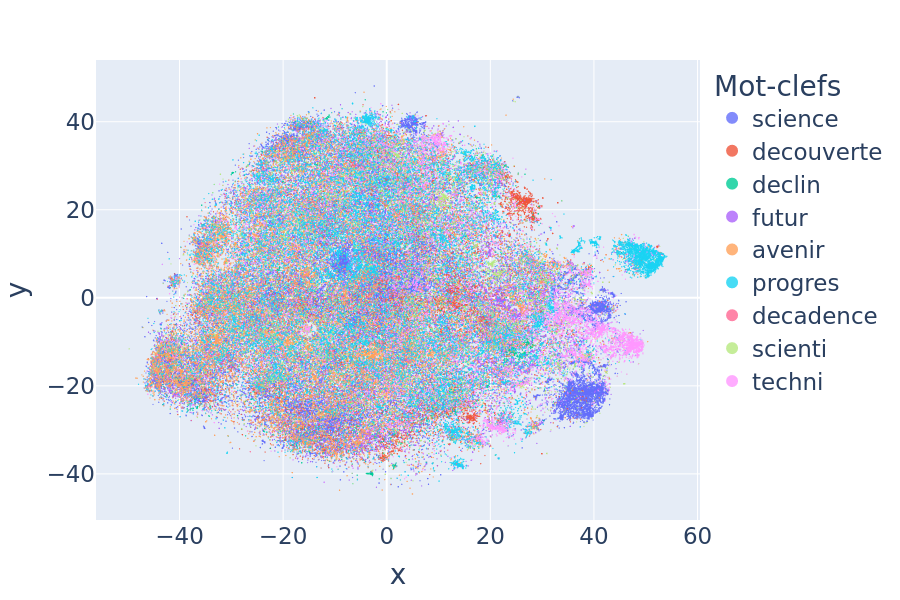

In [211]:
img = px.scatter(contextAvg,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [93]:
'''clustering = DBSCAN(eps= 0.4,metric ='euclidean').fit(np.array(kwsDf[['TSNEx','TSNEy']].apply(tuple, axis=1).tolist()))
kwsDf['cluster'] = clustering.labels_
kwsDf['cluster'] = kwsDf['cluster'].apply(str)
topLabel = kwsDf['cluster'].value_counts().index[:10]
#kwsDf['cluster'].value_counts()'''

In [215]:
'''kwsDf['cluster'] = kwsDf['cluster'].apply(lambda x : x if x in topLabel else topLabel[0]).apply(str)
img = px.scatter(kwsDf,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'cluster')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    font_size = 23,
    legend= {'itemsizing': 'constant'}
    legend_title="Cluster",
)
Image(img.to_image(format="png", width=900, height=500))'''

'kwsDf[\'cluster\'] = kwsDf[\'cluster\'].apply(lambda x : x if x in topLabel else topLabel[0]).apply(str)\nimg = px.scatter(kwsDf,\n                   x = \'TSNEx\',\n                   y = \'TSNEy\',\n                   color = \'cluster\')\n                   #mode = \'markers\',\n                   #marker = {\'size\': 2},\n                   #hoverinfo=\'skip\')\nimg.update_traces(marker={\'size\': 1.5,\'opacity\' :0.8})\nimg.update_layout(\n    #title="Plot Title",\n    font_size = 23,\n    legend= {\'itemsizing\': \'constant\'}\n    legend_title="Cluster",\n)\nImage(img.to_image(format="png", width=900, height=500))'

In [207]:
img = px.scatter(contextAvg.sample(1000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 8,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

/tmp/ipykernel_495535/3767382357.py:34: RuntimeWarning:

invalid value encountered in double_scalars

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



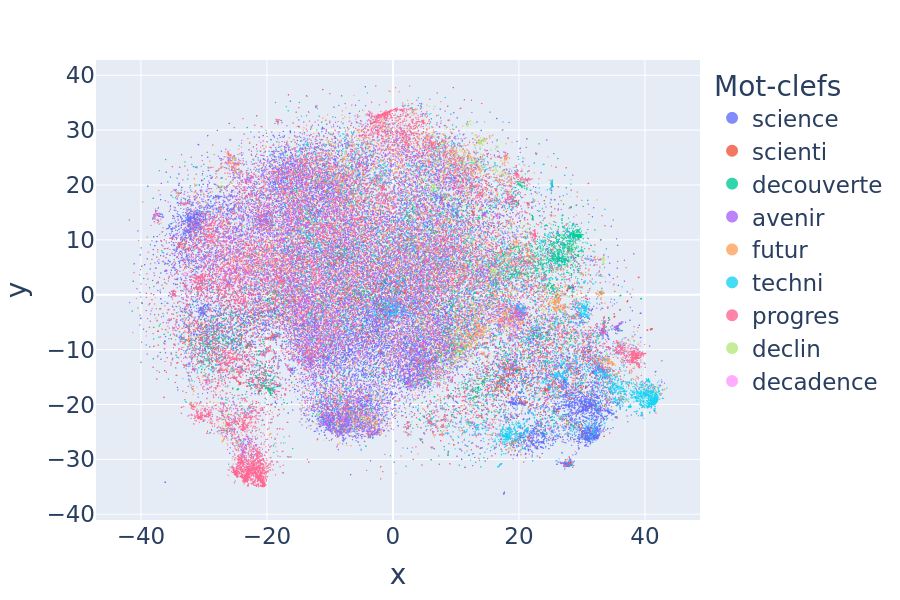

In [286]:
# idf weight
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvgIDF = pd.DataFrame(textDf.sample(frac=0.5).apply(lambda row : wsd.getContextAvg(row, window=20, weight= 'idf'), axis=1).explode().tolist(),
                          columns = ['ID','kw','word','vector','context'])
contextAvgIDF = contextAvgIDF[contextAvgIDF.context.apply(len)>50]
contextAvgIDF['TSNEx'],contextAvgIDF['TSNEy'] = zip(*TSNE(n_components = 2, 
                                                     perplexity = 100,
                                                     init = 'pca',
                                                     early_exaggeration = 30,
                                                     metric='euclidean', 
                                                     learning_rate = 'auto', 
                                                     n_iter_without_progress = 200,
                                                     square_distances=True,
                                                     n_iter = 1000).fit_transform(np.array(contextAvgIDF.vector.tolist()))[:,:2])
img = px.scatter(contextAvgIDF,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [287]:
img = px.scatter(contextAvgIDF.sample(1000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 8,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### Predict from average Word2Vec Skip-Gram, Window = 12

In [204]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvg = pd.DataFrame(textDf.sample(frac=0.5).apply(wsd.getPredictedAvg,axis=1).explode().tolist(),
                            columns = ['ID','kw','word','vector','context'])
predictedAvg = predictedAvg.dropna()

In [205]:
(predictedAvg['TSNEx'],
 predictedAvg['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvg.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



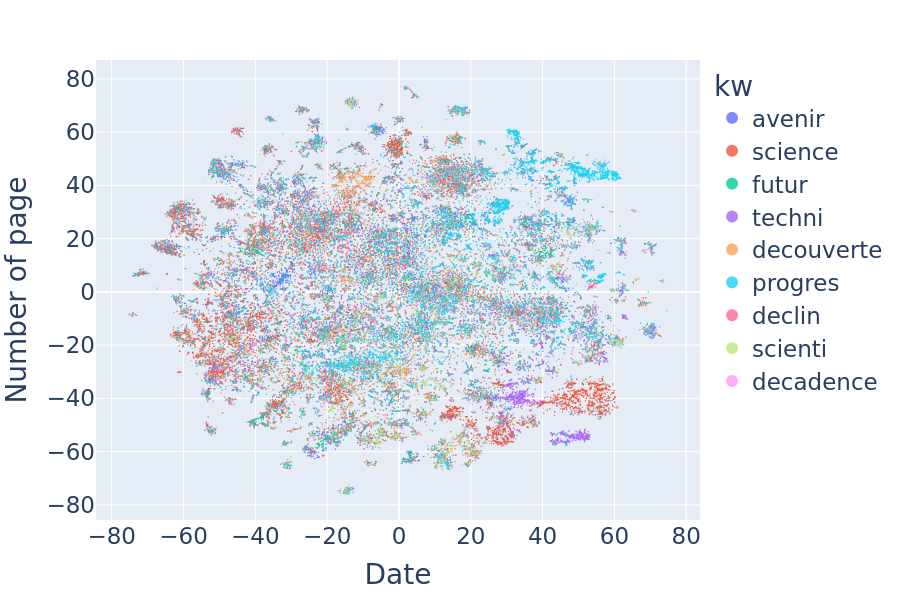

In [206]:
img = px.scatter(predictedAvg,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [208]:
img = px.scatter(predictedAvg.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### Predict from average Word2Vec Skip-Gram, Window = 20

In [212]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgWin20 = pd.DataFrame(textDf.sample(frac=0.5).apply(lambda row : wsd.getPredictedAvg(row,20), axis=1).explode().tolist(),
                            columns = ['ID','kw','word','vector','context'])
predictedAvgWin20 = predictedAvgWin20.dropna()


In [213]:
(predictedAvgWin20['TSNEx'],
 predictedAvgWin20['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvgWin20.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



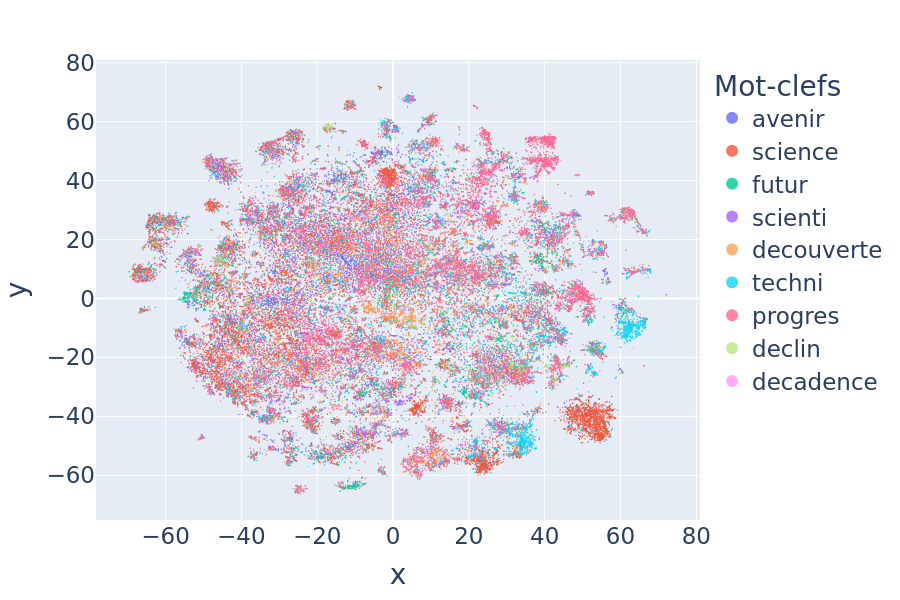

In [214]:
img = px.scatter(predictedAvgWin20,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [220]:
img = px.scatter(predictedAvgWin20.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### Context Average Word2Vec CBOW, Window = 12

In [216]:
wsdCBOW = VanillaWSD(Word2Vec.load("models/embeddings/Word2Vec_WSD_CBOW.model") ,keywords)

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



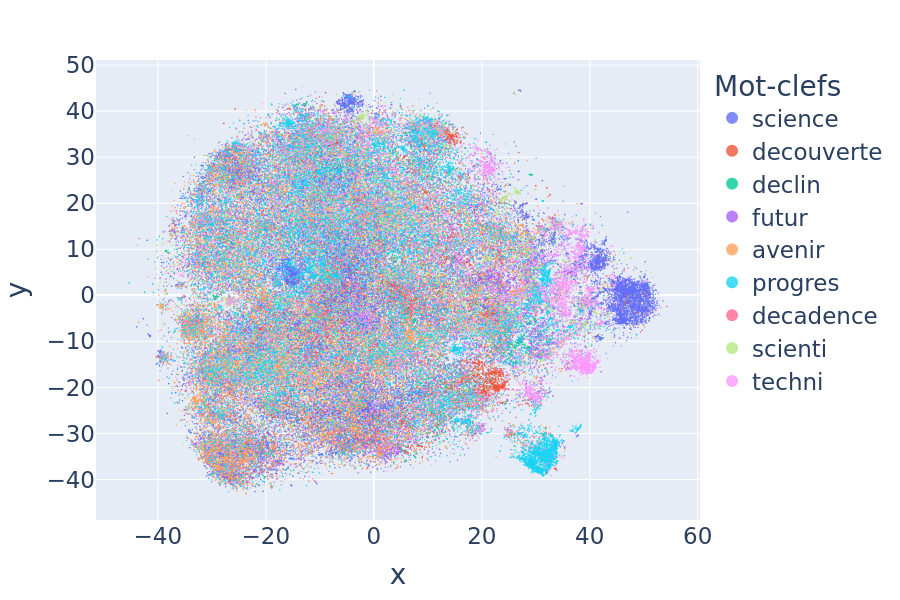

In [217]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvgCBOW = pd.DataFrame(textDf.apply(wsd.getContextAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','vector','context'])
contextAvgCBOW = contextAvgCBOW[contextAvgCBOW.context.apply(len)>25]
contextAvgCBOW['TSNEx'],contextAvgCBOW['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(contextAvgCBOW,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

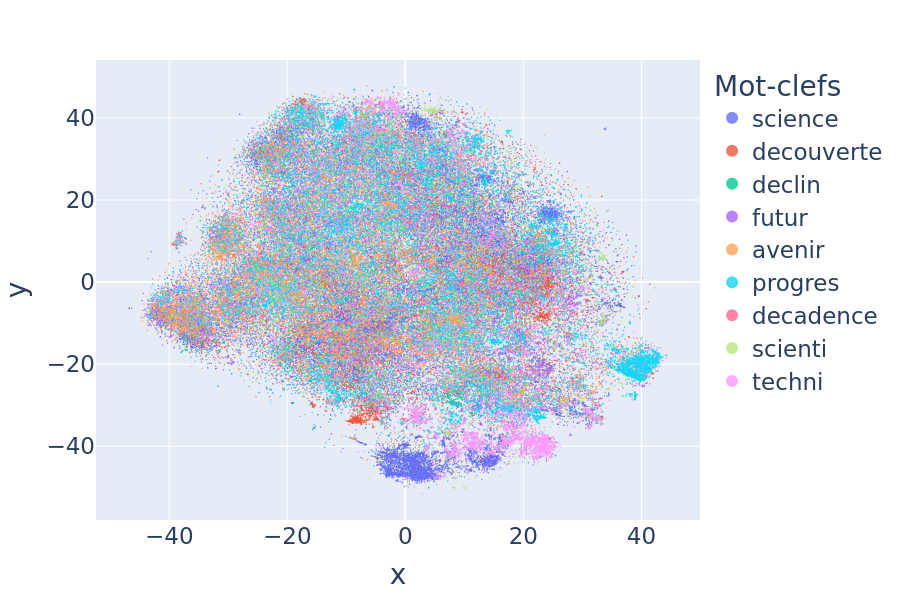

In [227]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvgCBOW = pd.DataFrame(textDf.apply(wsd.getContextAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','vector','context'])
contextAvgCBOW = contextAvgCBOW[contextAvgCBOW.context.apply(len)>25]
contextAvgCBOW['cTSNEx'],contextAvgCBOW['cTSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='cosine', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(contextAvgCBOW,
                   x = 'cTSNEx',
                   y = 'cTSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [225]:
img = px.scatter(contextAvgCBOW.sample(2000),
                   x = 'cTSNEx',
                   y = 'cTSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### predict from Average Word2Vec CBOW, Window = 12

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



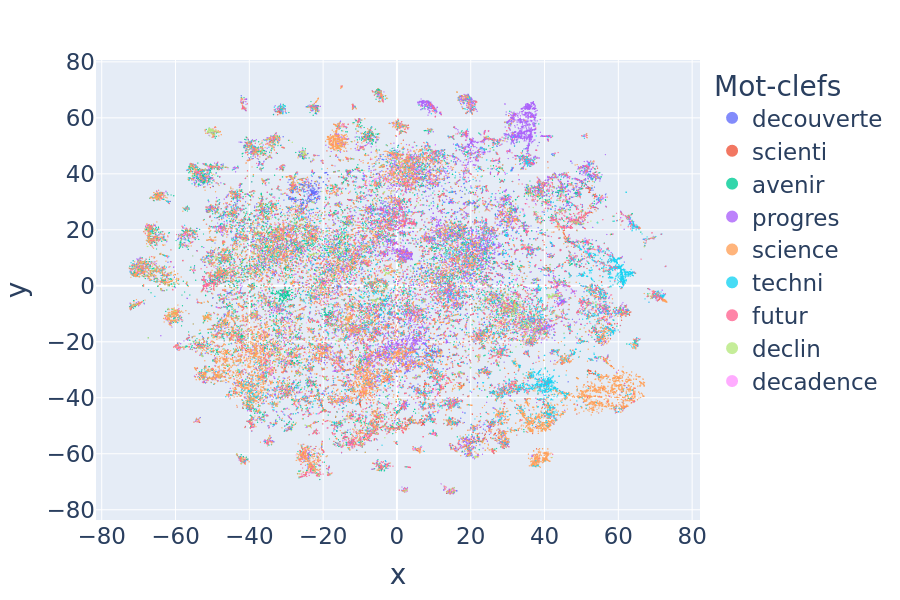

In [218]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgCBOW = pd.DataFrame(textDf.sample(frac=0.5).apply(wsd.getPredictedAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','vector','context'])
predictedAvgCBOW = predictedAvgCBOW[predictedAvgCBOW.context.apply(len)>25]
predictedAvgCBOW['TSNEx'],predictedAvgCBOW['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(predictedAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgCBOW,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



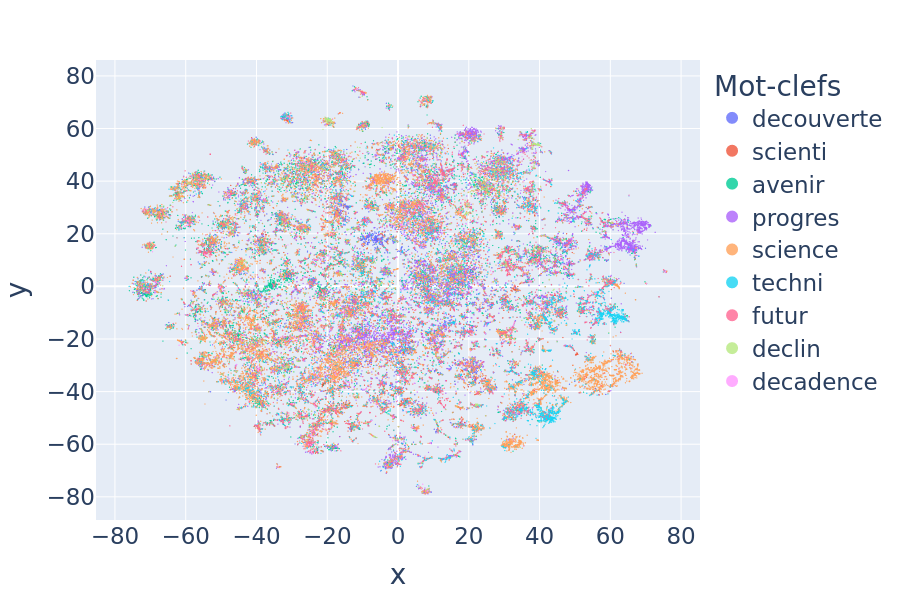

In [223]:
predictedAvgCBOW['cTSNEx'],predictedAvgCBOW['cTSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='cosine', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(predictedAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgCBOW,
                   x = 'cTSNEx',
                   y = 'cTSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [222]:
img = px.scatter(predictedAvgCBOW.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img